In [55]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
import torch

Please review the dataset and start outlining the way you would go about the model-building process with the goal of predicting the probability that the next thrown pitch will be a fastball, slider, change-up, etc.

We would like to see you assess the data, build a predictive model, and then evaluate that model and the success of its predictions,  with the understanding that delivering predictions with any degree of accuracy is unlikely in this short time span. Please provide any associated data analysis (plots, graphs, etc..), feature engineering, and code assembled in the form of a python notebook (or similar). Please include markup text to explain your analysis, graphs, etc. If you include a notebook, please also add an HTML version of that notebook, to facilitate review.

We would like you to spend no more than 4-6 hours on this project so please provide some details around future steps you would take if you had more time to finalize this project.  This is meant to be an open-ended/creative project, so focus your time where you see best. Let me know if you have any questions along the way. We aim to have a turnaround time to return the project in a week. We also understand that this isn't always possible, so if you need additional time, please let me know so I can keep the Hiring Team in the loop. 

In [58]:
data_df = pd.read_csv('pitches')

#Need to check out columns 29 and 30

C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\3472053155.py:1: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('pitches')


In [15]:
#Checking to make sure everything was split properly
for i in tqdm(range(len(data_df))):
    if len(data_df.loc[i]) != 125:
        print('Broken at index: ', i)


100%|██████████| 718961/718961 [02:52<00:00, 4165.15it/s]


In [59]:
data_df.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1


In [60]:
#looking at columns 29 and 30

columns = data_df.columns
print(data_df.columns[29:31])
print(data_df[columns[29]].describe())
print(data_df[columns[30]].describe())

Index(['event3', 'event4'], dtype='object')
count       334
unique        5
top       Error
freq        158
Name: event3, dtype: object
count        23
unique        1
top       Error
freq         23
Name: event4, dtype: object


In [61]:
data_df[columns[30]][data_df[columns[30]].isna() == False].value_counts()

Error    23
Name: event4, dtype: int64

In [62]:
###Just remove event4 since its basically the same value always
data_df = data_df.drop(columns[30], axis=1)

In [63]:
data_df[columns[29]][data_df[columns[29]].isna() == False].value_counts() ### this might be useful, but I want to start getting rid of columns that we definitely don't need

Error             158
Stolen Base 2B    128
Runner Out         27
Wild Pitch         15
Passed Ball         6
Name: event3, dtype: int64

In [64]:
data_df = data_df.drop(columns[-4:], axis=1) ###Remove created, added, modified, etc...
columns=data_df.columns

In [65]:
data_df.head()### Now I want to look at these 'runner' columns

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
columns[-49:]

Index(['runner1_id', 'runner1_start', 'runner1_end', 'runner1_event',
       'runner1_score', 'runner1_rbi', 'runner1_earned', 'runner2_id',
       'runner2_start', 'runner2_end', 'runner2_event', 'runner2_score',
       'runner2_rbi', 'runner2_earned', 'runner3_id', 'runner3_start',
       'runner3_end', 'runner3_event', 'runner3_score', 'runner3_rbi',
       'runner3_earned', 'runner4_id', 'runner4_start', 'runner4_end',
       'runner4_event', 'runner4_score', 'runner4_rbi', 'runner4_earned',
       'runner5_id', 'runner5_start', 'runner5_end', 'runner5_event',
       'runner5_score', 'runner5_rbi', 'runner5_earned', 'runner6_id',
       'runner6_start', 'runner6_end', 'runner6_event', 'runner6_score',
       'runner6_rbi', 'runner6_earned', 'runner7_id', 'runner7_start',
       'runner7_end', 'runner7_event', 'runner7_score', 'runner7_rbi',
       'runner7_earned'],
      dtype='object')

In [67]:
data_df[columns[-49:]].isna().sum() #### OK these are all NaNs..... so just remove them

runner1_id        718961
runner1_start     718961
runner1_end       718961
runner1_event     718961
runner1_score     718961
runner1_rbi       718961
runner1_earned    718961
runner2_id        718961
runner2_start     718961
runner2_end       718961
runner2_event     718961
runner2_score     718961
runner2_rbi       718961
runner2_earned    718961
runner3_id        718961
runner3_start     718961
runner3_end       718961
runner3_event     718961
runner3_score     718961
runner3_rbi       718961
runner3_earned    718961
runner4_id        718961
runner4_start     718961
runner4_end       718961
runner4_event     718961
runner4_score     718961
runner4_rbi       718961
runner4_earned    718961
runner5_id        718961
runner5_start     718961
runner5_end       718961
runner5_event     718961
runner5_score     718961
runner5_rbi       718961
runner5_earned    718961
runner6_id        718961
runner6_start     718961
runner6_end       718961
runner6_event     718961
runner6_score     718961


In [68]:
data_df = data_df.drop(columns[-49:], axis=1)
columns=data_df.columns

In [69]:
print(len(columns)) #nice

71


In [70]:
data_df.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
print(data_df['pitch_type'].isna().sum())
print(data_df['type_confidence'].isna().sum()) ### these are our y variables so we should remove rows where these are NaNs (save for end though so we don't lose too much data)

2280
2280


In [82]:
#data_df = data_df[data_df['pitch_type'].isna() == False]

In [83]:
#data_df['type_confidence'].isna().sum()

0

In [72]:
data_df['pitch_type'].value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [73]:
data_df['type_confidence'].describe()

count    716681.000000
mean          1.404510
std           0.660533
min           0.000000
25%           0.901000
50%           2.000000
75%           2.000000
max           2.000000
Name: type_confidence, dtype: float64

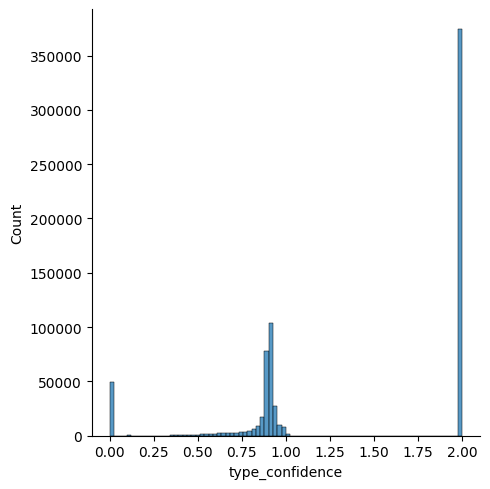

In [74]:
sns.displot(data_df['type_confidence'])
plt.show;

In [40]:
### Seems like confidence is generally high, but there are some outliers
### I don't think we should train on data where we have low confidence in the label... lets find a reasonable cutoff based on the above


In [75]:
print('Number of observations below cutoff',len(data_df[data_df['type_confidence'] < 0.75]))
print('Number of observations above cutoff',len(data_df[data_df['type_confidence'] >= 0.75]))

Number of observations below cutoff 72492
Number of observations above cutoff 644189


In [90]:
72492/(72492+644189) ### cutting 10% of the data isn't great but it's not terrible either and I think it's worth it. SAVE this for later

0.10114960491487844

In [91]:
#data_df = data_df[data_df['type_confidence'] >= 0.75]
###MISTAKE HERE -- so I'm leaving this in, but I realized that cutting pitches randomly messes up the lag numbers. I should have cut these after creating the lag variables so that the lag variables are still correct. 
# I'm leaving this in because I think it's important to show that I realized this and I'm not just trying to hide it. If I have time, I will try to fix this later on. 

##I ended up coming back and undoing this and redoing it correctly later on in the data processing :D

In [76]:
print(len(data_df))
data_df.head()

718961


,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
data_df.isna().sum().to_csv('missing_values.csv') ##too long cant see


In [97]:
columns[0]

'uid'

In [98]:
''''Column	Nas
event2	636739
event3	643881
score	593925
pitch_tfs	275
pitch_tfs_zulu	275
cc	619307
on_1b	450154
on_2b	520462
on_3b	581554
'''

### I don't think we're gonna use pitch_tfs anyways so I'm just gonna drop the columns

"'Column\tNas\nevent2\t636739\nevent3\t643881\nscore\t593925\npitch_tfs\t275\npitch_tfs_zulu\t275\ncc\t619307\non_1b\t450154\non_2b\t520462\non_3b\t581554\n"

In [77]:
list(columns).index('pitch_tfs_zulu')

37

In [78]:
data_df = data_df.drop('pitch_tfs', axis=1)

In [79]:
data_df = data_df.drop('pitch_tfs_zulu', axis=1)

In [80]:
columns = data_df.columns

In [81]:
##What is cc?

data_df['cc'].describe()

count                                                 27937
unique                                                23292
top       |pitcher| has his out pitch working today, rec...
freq                                                     58
Name: cc, dtype: object

In [82]:
data_df['cc'].value_counts()

|pitcher| has his out pitch working today, recording all 4 of his strikeouts with the slider so far.                                                      58
Justin Masterson is having trouble locating his sinker, missing the strike zone with his last three.                                                      24
Charlie Morton is having trouble locating his two-seam fastball, missing the strike zone with his last three.                                             23
Ervin Santana is having trouble locating his four-seam fastball, missing the strike zone with his last three.                                             22
Clayton Kershaw is having trouble locating his four-seam fastball, missing the strike zone with his last three.                                           21
                                                                                                                                                          ..
Clay Buchholz has thrown 83 pitches but has plenty left in

In [83]:
### I think all this text is probably too much to manage for a short project like this. You could probably use NLP on a lot of these text columns to maybe get some more info but I can't do that in 4-6 hours so lets just drop

In [84]:
data_df = data_df.drop('cc', axis=1)
columns = data_df.columns

In [85]:
data_df['score'].describe()

count     56096
unique        1
top           T
freq      56096
Name: score, dtype: object

In [86]:
## this is an indicator of whether runs were scored due to this at bat. We can't use this as a feature because it's a result of the pitch, not a feature of the pitch, 
#but we could use a lagged version of this as a feature to predict the next pitch, save it for now

In [87]:
#the on_1b, 2, 3 are useful because we can use it to generate the number of runners on base, which is a useful feature, I think the NaNs are jsut when there are no runners on that base

In [88]:
''''Column	Nas
event2	636739
event3	643881
'''

"'Column\tNas\nevent2\t636739\nevent3\t643881\n"

In [89]:
## these events are mostly NaNs. Lets at least take a look

data_df['event2'].value_counts()

Error                   2640
Runner Out              2250
Stolen Base 2B          1296
Caught Stealing 2B       771
Wild Pitch               705
Stolen Base 3B           329
Passed Ball              132
Caught Stealing 3B       117
Stolen Base Home          18
Caught Stealing Home      11
Pickoff 1B                11
Pickoff 3B                10
Pickoff Error 2B           5
Pickoff Error 1B           4
Name: event2, dtype: int64

In [90]:
data_df['event'].value_counts()

Strikeout               168261
Groundout               125901
Single                   97499
Flyout                   90591
Walk                     79412
Pop Out                  33656
Double                   28568
Lineout                  22342
Home Run                 15797
Forceout                 12393
Grounded Into DP         11031
Field Error               6023
Intent Walk               5158
Hit By Pitch              4918
Sac Fly                   4039
Triple                    3131
Sac Bunt                  3081
Double Play               1870
Fielders Choice Out       1226
Runner Out                1166
Strikeout - DP             915
Bunt Groundout             748
Fielders Choice            445
Bunt Pop Out               371
Fan interference           141
Catcher Interference       104
Batter Interference         88
Sac Fly DP                  66
Bunt Lineout                13
Triple Play                  7
Name: event, dtype: int64

In [91]:
data_df['event3'].value_counts()

Error             158
Stolen Base 2B    128
Runner Out         27
Wild Pitch         15
Passed Ball         6
Name: event3, dtype: int64

In [92]:
data_df['event2'][data_df['event2'] == 'Error']

184       Error
185       Error
186       Error
763       Error
764       Error
          ...  
718026    Error
718027    Error
718053    Error
718054    Error
718055    Error
Name: event2, Length: 2640, dtype: object

In [93]:
###I'm going to assume that 'Error' for event2 and event3 are actual errors, and if there are Errors in both columns then there were two errors on the play?

In [ ]:
#data_df[(data_df['event2'] == 'Error') & (data_df['event3'] == 'Error')].to_csv('double_errors.csv') 

In [129]:
## OK yeah that actually is in the description for each appearance

In [95]:
data_df = data_df.drop('year', axis=1) ###DRop year since its always 2011
columns = data_df.columns

In [96]:
data_df = data_df.drop('at_bat_des', axis=1) ###Drop at_bat_des 
columns = data_df.columns

In [98]:
data_df[data_df['pitch_type'].isna()]

,uid,game_pk,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,...,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,on_1b,on_2b,on_3b
0,14143226,286874,2011-03-31,108,118,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143227,286874,2011-03-31,108,118,1,1,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14143228,286874,2011-03-31,108,118,1,1,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14143229,286874,2011-03-31,108,118,1,1,1,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14143230,286874,2011-03-31,108,118,1,1,2,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718652,19836755,317072,2011-10-27,138,140,10,0,98,3,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445055.0,NaN
718851,19838087,317073,2011-10-28,138,140,5,0,45,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405395.0,501800.0
718852,19838088,317073,2011-10-28,138,140,5,0,45,2,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405395.0,501800.0
718853,19838089,317073,2011-10-28,138,140,5,0,45,3,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405395.0,501800.0


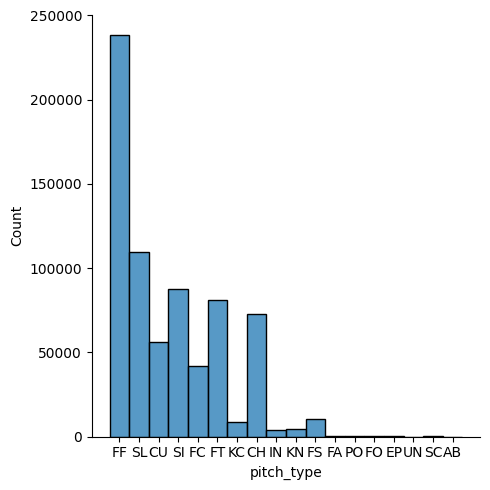

In [99]:
sns.displot(data_df['pitch_type']) ##start looking at how imbalanced the labels are gonna be....
plt.show;

FF = Four Seam Fastball   SL = Slider   CU = Curveball  SI = Sinker    FC = Fastball/Cutter    FT = Two Seam Fastball

KC = Knuckle-Curve  CH = Changeup   KN = Knuckleball   FS = Splitter   FA = Four Seam Fastball   FO = Forkball   EP = Eephus    SC = Screwball


In [100]:
data_df['pitch_type'].value_counts() ### I think some of these will get cut anyways when I remove the low confidence labels but probably still very imbalanced

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [101]:
data_df['pitch_type'][data_df['pitch_type'] == 'FA'] = 'FF' ###from what I read online FA is FF? There were hardly any FA anyways

C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\915400684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['pitch_type'][data_df['pitch_type'] == 'FA'] = 'FF'


In [102]:
data_df.head()

,uid,game_pk,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,...,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,on_1b,on_2b,on_3b
0,14143226,286874,2011-03-31,108,118,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14143227,286874,2011-03-31,108,118,1,1,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14143228,286874,2011-03-31,108,118,1,1,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14143229,286874,2011-03-31,108,118,1,1,1,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14143230,286874,2011-03-31,108,118,1,1,2,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
#data_df.to_csv('current_data_monday_morning_end.csv')

In [5]:
#data_df = pd.read_csv('current_data_monday_morning_end.csv')

C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\3742532493.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('current_data_monday_morning_end.csv')


In [103]:
columns = data_df.columns

In [105]:
data_df[columns[25]].value_counts()

Strikeout               168261
Groundout               125901
Single                   97499
Flyout                   90591
Walk                     79412
Pop Out                  33656
Double                   28568
Lineout                  22342
Home Run                 15797
Forceout                 12393
Grounded Into DP         11031
Field Error               6023
Intent Walk               5158
Hit By Pitch              4918
Sac Fly                   4039
Triple                    3131
Sac Bunt                  3081
Double Play               1870
Fielders Choice Out       1226
Runner Out                1166
Strikeout - DP             915
Bunt Groundout             748
Fielders Choice            445
Bunt Pop Out               371
Fan interference           141
Catcher Interference       104
Batter Interference         88
Sac Fly DP                  66
Bunt Lineout                13
Triple Play                  7
Name: event, dtype: int64

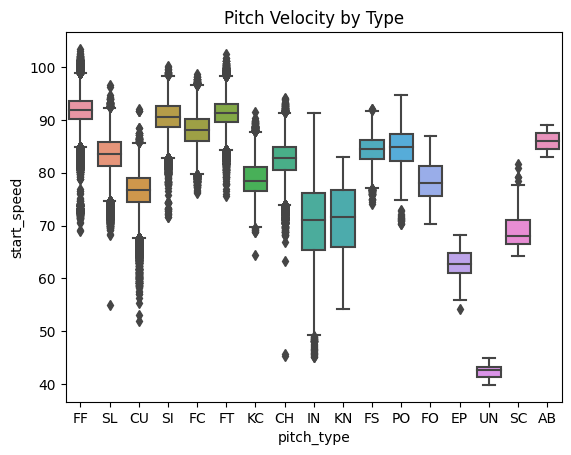

In [106]:
sns.boxplot(x=data_df['pitch_type'], y=data_df['start_speed']) ###Intuitive but ultimately not useful since it doesn't inform us about the next pitch
plt.title('Pitch Velocity by Type')
plt.show;

In [ ]:
sns.lineplot(x=data_df['inning'], y = data_df['start_speed'], errorbar=None) ###makes sense, pitchers get tired
plt.title('Pitch Speed by Inning')
plt.show;

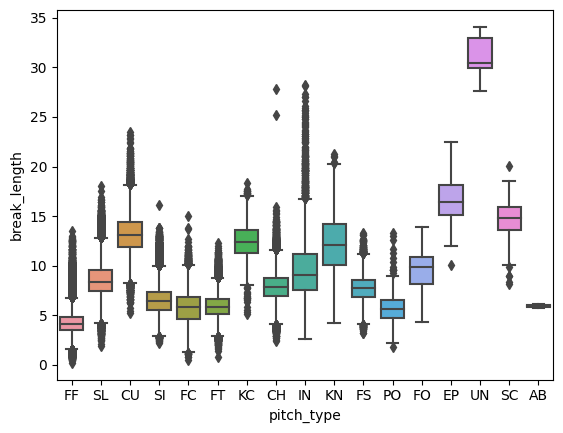

In [108]:
sns.boxplot(x=data_df['pitch_type'], y=data_df['break_length'])
plt.show; ##love a good eephus pitch

<Axes: xlabel='pitch_type', ylabel='nasty'>

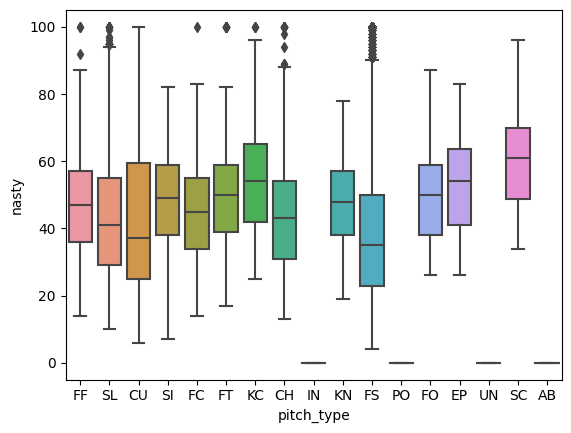

In [109]:
sns.boxplot(x=data_df['pitch_type'], y=data_df['nasty'])
plt.show;
#nasty doesn't seem very useful, they aren't very different from eachother, but we can include it anyways

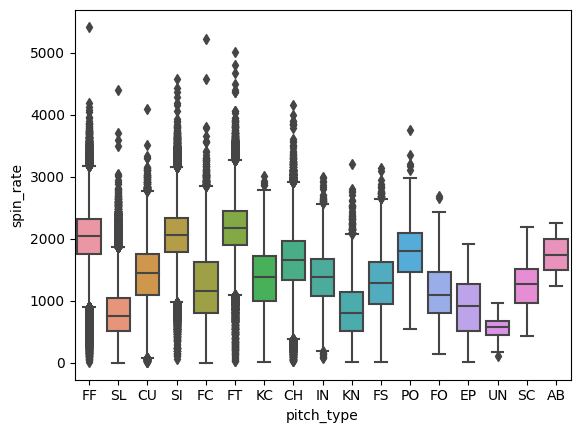

In [110]:
#Spin Rate
sns.boxplot(x=data_df['pitch_type'], y=data_df['spin_rate'])
plt.show; #### I don't think this is very useful for predicting the next pitch, unless you're comparing a pitcher's spin rate average on that day versus previous days
#Like does he have it today, or not? Given 4-6 hours, I don't think I can do that, so I'm gonna drop it

In [111]:
grouped = data_df.groupby('pitch_type')['pitcher_id'].nunique()

print(grouped)

pitch_type
AB      2
CH    552
CU    372
EP      9
FC    209
FF    626
FO      3
FS     62
FT    400
IN    432
KC     38
KN      5
PO    242
SC      4
SI    204
SL    535
UN     12
Name: pitcher_id, dtype: int64


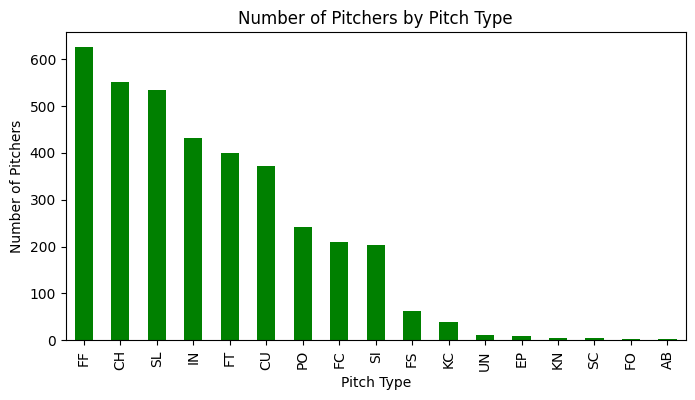

In [112]:
grouped.sort_values(ascending=False, inplace=True)  

plt.figure(figsize=(8,4))  

grouped.plot(kind='bar', color='green')  

plt.title('Number of Pitchers by Pitch Type')  
plt.xlabel('Pitch Type')  
plt.ylabel('Number of Pitchers') 

plt.show;

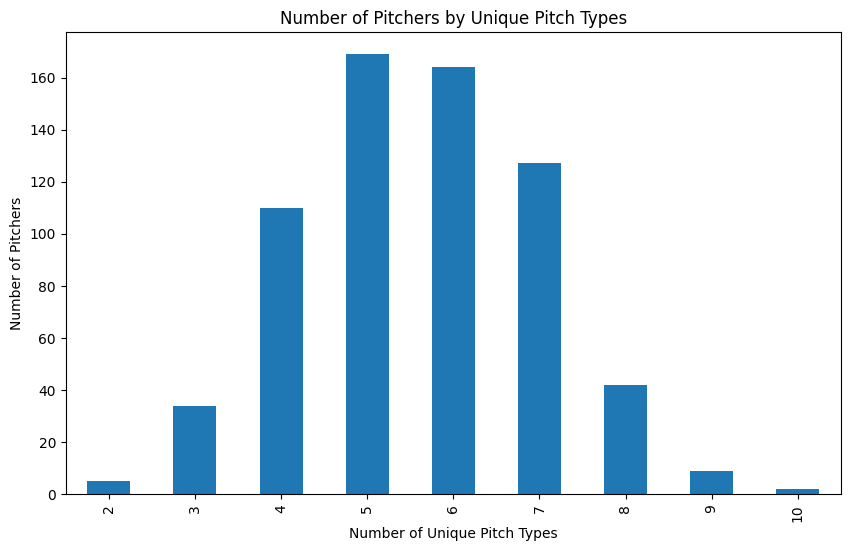

In [113]:
pitch_types_per_pitcher = data_df.groupby('pitcher_id')['pitch_type'].nunique()
pitchers_per_pitch_type = pitch_types_per_pitcher.value_counts()
pitchers_per_pitch_type.sort_index(inplace=True)
plt.figure(figsize=(10,6))
pitchers_per_pitch_type.plot(kind='bar')

plt.title('Number of Pitchers by Unique Pitch Types')
plt.xlabel('Number of Unique Pitch Types')
plt.ylabel('Number of Pitchers')

plt.show()

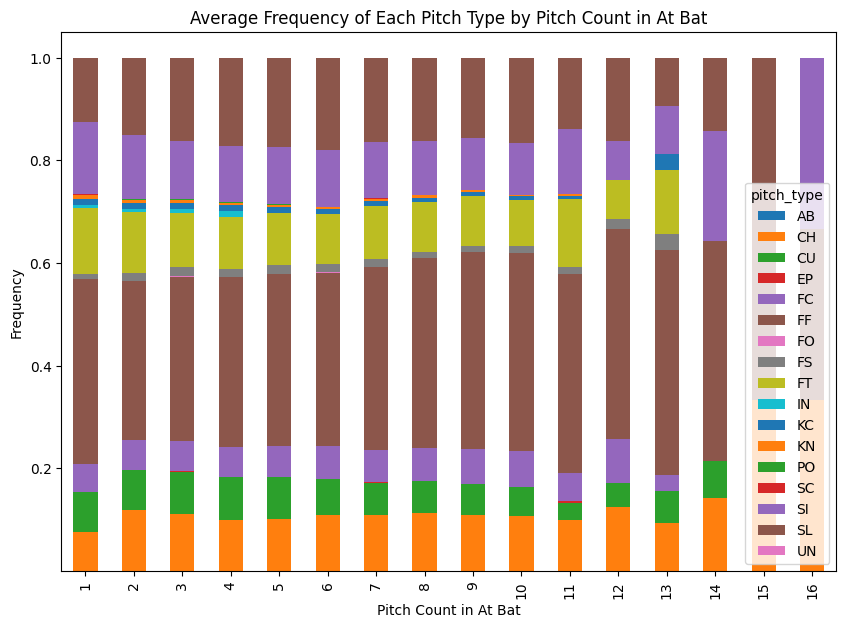

In [114]:
# Calculate frequency of each pitch type at each pitch count
pitch_counts = pd.crosstab(data_df['pcount_at_bat'], data_df['pitch_type'])

# Normalize each row to get frequencies
pitch_freqs = pitch_counts.div(pitch_counts.sum(axis=1), axis=0)

#print(pitch_freqs)

pitch_freqs.plot(kind='bar', stacked=True, figsize=(10,7))
plt.ylabel('Frequency')
plt.xlabel('Pitch Count in At Bat')
plt.title('Average Frequency of Each Pitch Type by Pitch Count in At Bat')
plt.show()


In [115]:
##There are too many pitch types here for this to be a good chart. I think in a non-assignment setting I would try to bin these to make it more readable -- and also I think it would be better for prediction too
pitch_freqs


pitch_type,AB,CH,CU,EP,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
pcount_at_bat,,,,,,,,,,,,,,,,,
1,0.000000,0.076762,0.077448,0.000117,0.054141,0.359928,0.000181,0.009709,0.129435,0.004533,0.013130,0.006767,0.001224,0.000101,0.140538,0.125977,0.000011
2,0.000000,0.118955,0.077040,0.000150,0.059280,0.308856,0.000497,0.015813,0.118068,0.005621,0.012116,0.006999,0.000905,0.000234,0.125294,0.150150,0.000024
3,0.000007,0.111238,0.082499,0.000235,0.059618,0.320051,0.000809,0.017209,0.105219,0.007659,0.012346,0.006416,0.000773,0.000162,0.113541,0.162181,0.000037
4,0.000000,0.099983,0.083630,0.000275,0.057417,0.330632,0.000589,0.016559,0.100956,0.011295,0.010705,0.005343,0.000521,0.000196,0.110600,0.171248,0.000049
5,0.000000,0.101542,0.081215,0.000229,0.060218,0.334948,0.000472,0.017401,0.100902,0.001143,0.010819,0.004922,0.000229,0.000122,0.111919,0.173904,0.000015
6,0.000029,0.109484,0.069731,0.000258,0.063426,0.338397,0.000258,0.015993,0.098020,0.000057,0.009171,0.004758,0.000115,0.000201,0.109627,0.180476,0.000000
7,0.000000,0.108439,0.063861,0.000069,0.063722,0.356832,0.000069,0.014445,0.104499,0.000000,0.008985,0.004492,0.000000,0.000207,0.110374,0.164006,0.000000
8,0.000000,0.111983,0.062620,0.000174,0.064539,0.371184,0.000000,0.010989,0.097157,0.000000,0.008373,0.005058,0.000174,0.000349,0.105355,0.162044,0.000000
9,0.000000,0.108789,0.060333,0.000000,0.067933,0.383373,0.000475,0.011876,0.097862,0.000000,0.007126,0.003800,0.000000,0.000000,0.102138,0.156295,0.000000


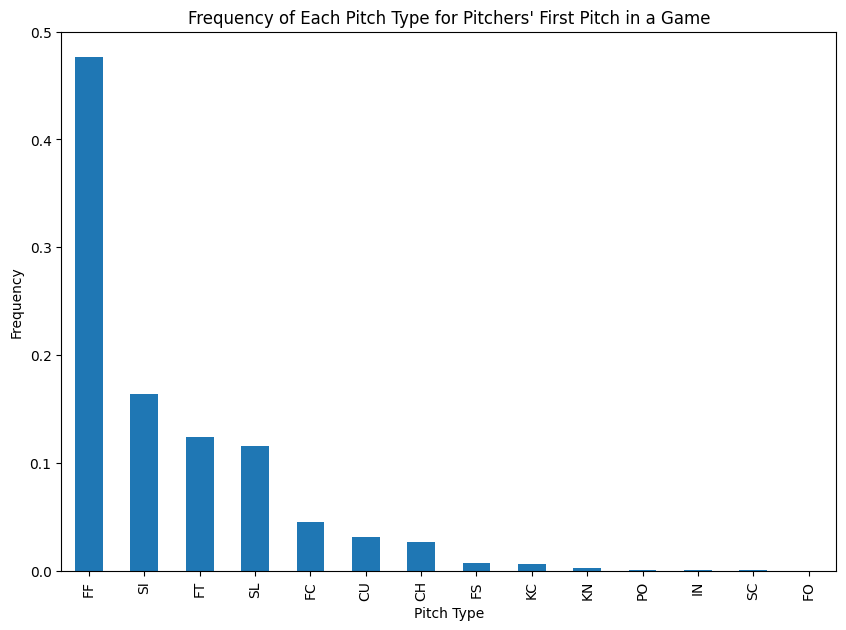

In [116]:
# Isolate each pitcher's first pitch in each game
first_pitches = data_df.sort_values(['pitcher_id', 'game_pk', 'pcount_pitcher']).groupby(['pitcher_id', 'game_pk']).first().reset_index()

# Calculate frequency of each pitch type
first_pitch_freqs = first_pitches['pitch_type'].value_counts(normalize=True)


first_pitch_freqs.plot(kind='bar', figsize=(10,7))
plt.ylabel('Frequency')
plt.xlabel('Pitch Type')
plt.title('Frequency of Each Pitch Type for Pitchers\' First Pitch in a Game')
plt.show()


Feature Engineering

In [48]:
### I think at this point, I'll get rid of most of the coordinate based features. They seem like they're more useful in determining what type of pitch the current pitch is, which isn't useful for prediction.
## we have the approximate labels already, with a short turn around window, have to assume that pruning to above .75 confidence is good enough to justify their labels
##sz_top and sz_bot are interesting from a lag variable perspective, but it seems like it might just complicate things and add data leakage if I mess up -- remove for now and chalk this up as "nice to add" later
#x, y, sv_id, pfx_x pfx_z, px, pz, z0, x0, y0, vx0, vz0, vy0, ax, az ,ay

##I also will get rid of features that will cause data leakage and won't be useful as a lag variable:
#is_final_pitch, final_balls, final_strikes, final_outs, start_tfs, start_tfs_zulu

#The rest will be lagged and one-hot encoded. Additionally, at the end we will remove all the low-confidence labeled pitches, then split off hte target variables and save the data

In [117]:
columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'is_final_pitch', 'final_balls', 'final_strikes',
       'final_outs', 'start_tfs', 'start_tfs_zulu', 'batter_id', 'stand',
       'b_height', 'pitcher_id', 'p_throws', 'event', 'event2', 'event3',
       'away_team_runs', 'home_team_runs', 'score', 'pitch_des', 'pitch_id',
       'type', 'x', 'y', 'sv_id', 'start_speed', 'end_speed', 'sz_top',
       'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz', 'x0', 'z0', 'y0', 'vx0', 'vz0',
       'vy0', 'ax', 'az', 'ay', 'break_length', 'break_y', 'break_angle',
       'pitch_type', 'type_confidence', 'zone', 'nasty', 'spin_dir',
       'spin_rate', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [121]:
to_drop = ['x', 'y', 'sv_id', 'pfx_x', 'pfx_z', 'px', 'pz', 'z0', 'x0', 'y0', 'vx0', 'vz0', 'vy0','ax','ay','az', 'is_final_pitch', 'final_balls', 'final_strikes', 'final_outs', 'start_tfs', 'start_tfs_zulu', 'sz_top', 'sz_bot']

In [122]:
data_df = data_df.drop(to_drop, axis=1)

In [125]:
columns = data_df.columns
print(columns)

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'event', 'event2', 'event3', 'away_team_runs',
       'home_team_runs', 'score', 'pitch_des', 'pitch_id', 'type',
       'start_speed', 'end_speed', 'break_length', 'break_y', 'break_angle',
       'pitch_type', 'type_confidence', 'zone', 'nasty', 'spin_dir',
       'spin_rate', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')


In [126]:
data_df['pitch_des'].value_counts()

Ball                         245007
Called Strike                125919
Foul                         117833
In play, out(s)               89333
Swinging Strike               59011
In play, no out               30880
In play, run(s)               16000
Ball In Dirt                  12901
Foul Tip                       5118
Intent Ball                    4375
Swinging Strike (Blocked)      4233
Foul (Runner Going)            2972
Foul Bunt                      2709
Hit By Pitch                   1589
Pitchout                        560
Missed Bunt                     497
Automatic Ball                   21
Swinging Pitchout                 3
Name: pitch_des, dtype: int64

In [129]:
data_df['type'].value_counts() ### I think pitch_des is too descriptive and type is too vague, but maybe we can use them to create a new feature that is more useful

S    318295
B    264453
X    136213
Name: type, dtype: int64

In [ ]:
#New Categories:
#Ball Unintentional (Ball, Ball in Dirt, Hit by Pitch)
#Ball Intentional (Pitchout, Intent Ball, Automatic Ball)
#Called Strike (Called Strike)
#Strike Swinging (includes fouls) (Swinging Strike, Foul Tip, Swinging Strike(Blocked), Foul (Running Going), Foul,  Swinging Pitchout)
#Bunt Shown (Missed Bunt, Foul Bunt)
#In Play (outs, no out, runs)
#

In [133]:
rebucket_dict = {
    "Ball": "Ball Unintentional",
    "Ball In Dirt": "Ball Unintentional",
    "Hit By Pitch": "Ball Unintentional",
    "Pitchout": "Ball Intentional",
    "Intent Ball": "Ball Intentional",
    "Automatic Ball": "Ball Intentional",
    "Called Strike": "Called Strike",
    "Swinging Strike": "Strike Swinging",
    "Foul Tip": "Strike Swinging",
    "Swinging Strike (Blocked)": "Strike Swinging",
    "Foul (Runner Going)": "Strike Swinging",
    "Foul": "Strike Swinging",
    "Swinging Pitchout": "Strike Swinging",
    "Missed Bunt": "Bunt Shown",
    "Foul Bunt": "Bunt Shown",
    "In play, out(s)": "In Play",
    "In play, no out": "In Play",
    "In play, run(s)": "In Play",
}


In [134]:

data_df['pitch_des'] = data_df['pitch_des'].replace(rebucket_dict)


print(data_df['pitch_des'].value_counts())


Ball Unintentional    259497
Strike Swinging       189170
In Play               136213
Called Strike         125919
Ball Intentional        4956
Bunt Shown              3206
Name: pitch_des, dtype: int64


In [136]:
#Want to visualize the data a bit more to see what else is needed to to be done:

data_df.head(40).to_csv('tuesday_morning.csv')

In [137]:
#Change 'on_1b', 'on_2b', 'on_3b' to 0 if no player on base, 1 otherwise
data_df['on_1b'] = data_df['on_1b'].apply(lambda x: 0 if pd.isna(x) else 1)
data_df['on_2b'] = data_df['on_2b'].apply(lambda x: 0 if pd.isna(x) else 1)
data_df['on_3b'] = data_df['on_3b'].apply(lambda x: 0 if pd.isna(x) else 1)


In [138]:
data_df['on_1b'].value_counts() #great

0    502638
1    216323
Name: on_1b, dtype: int64

In [140]:
###One thing I think i would do if this were me, would be to bucket all the pitch types such that its just fastball, breaking ball, changeup, and other because I think that is what is most important to know as a hitter for whats coming
### but the assignment asks for probabilities of each pitch type, so we can stick without this for now, but I'm going to add some one-hots for previous pitch types in the pitcher's repertoire

In [141]:
columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'event', 'event2', 'event3', 'away_team_runs',
       'home_team_runs', 'score', 'pitch_des', 'pitch_id', 'type',
       'start_speed', 'end_speed', 'break_length', 'break_y', 'break_angle',
       'pitch_type', 'type_confidence', 'zone', 'nasty', 'spin_dir',
       'spin_rate', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [142]:
data_df = data_df.drop(['spin_rate', 'spin_dir'], axis=1)

In [143]:
columns = data_df.columns

In [144]:
columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'event', 'event2', 'event3', 'away_team_runs',
       'home_team_runs', 'score', 'pitch_des', 'pitch_id', 'type',
       'start_speed', 'end_speed', 'break_length', 'break_y', 'break_angle',
       'pitch_type', 'type_confidence', 'zone', 'nasty', 'on_1b', 'on_2b',
       'on_3b'],
      dtype='object')

In [146]:
data_df = data_df.drop(['start_speed','end_speed', 'break_length', 'break_y','break_angle','type'], axis=1)
columns = data_df.columns
columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'event', 'event2', 'event3', 'away_team_runs',
       'home_team_runs', 'score', 'pitch_des', 'pitch_id', 'pitch_type',
       'type_confidence', 'zone', 'nasty', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [150]:
### Adding lagged pitch_types for each batter, so it's what hte pitcher last threw to the batter
data_df['lagged_pitch_type'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['pitch_type'].shift(1)
data_df['lagged_pitch_type_2'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['pitch_type'].shift(2)
data_df['lagged_pitch_type_3'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['pitch_type'].shift(3)


In [151]:
##Now adding a lag for each event so we can see what happened on the last at-bat

data_df['lagged_event'] = data_df.groupby(['game_pk', 'team_id_b'])['event'].shift(1)
data_df['lagged_event2'] = data_df.groupby(['game_pk', 'team_id_b'])['event2'].shift(1)
data_df['lagged_event3'] = data_df.groupby(['game_pk', 'team_id_b'])['event3'].shift(1)


In [152]:
##Adding additional lagged variables

data_df['lagged_pitch_des'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['pitch_des'].shift(1)
data_df['lagged_zone'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['zone'].shift(1)
data_df['lagged_nasty'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['nasty'].shift(1)


In [316]:
data_df['lagged_type_confidence'] = data_df.groupby(['game_pk', 'team_id_b', 'batter_id'])['type_confidence'].shift(1)

In [153]:
##Pitcher is home team indicator
data_df['pitcher_is_home'] = (data_df['top'] == 1).astype(int)


In [199]:
###differential for if pitcher is winning

data_df['pitcher_team_winning_by'] = data_df.apply(lambda row: row['home_team_runs'] - row['away_team_runs'] if row['pitcher_is_home'] else row['away_team_runs'] - row['home_team_runs'], axis=1)


In [296]:
df = data_df.copy()

# Define the pitch types
pitch_types = df['pitch_type'].unique().tolist()

df.columns


Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'b_height', 'pitcher_id',
       'p_throws', 'event', 'event2', 'event3', 'away_team_runs',
       'home_team_runs', 'score', 'pitch_des', 'pitch_id', 'pitch_type',
       'type_confidence', 'zone', 'nasty', 'on_1b', 'on_2b', 'on_3b',
       'lagged_pitch_type', 'lagged_pitch_type_2', 'lagged_pitch_type_3',
       'lagged_event', 'lagged_event2', 'lagged_event3', 'lagged_pitch_des',
       'lagged_zone', 'lagged_nasty', 'pitcher_is_home',
       'pitcher_team_winning_by'],
      dtype='object')

In [297]:
df['pitch_type'] = df['pitch_type'].fillna('UN')

In [298]:
df.pitch_type.value_counts()

pitch_types = df['pitch_type'].unique().tolist()

In [300]:
##creating a frequency column for each pitch type for each pitcher

###Create dummy columns for each pitch type
df['pitch_type_original'] = df['pitch_type']
df = pd.get_dummies(df, columns=['pitch_type'], prefix='', prefix_sep='',)

###Create a column to track the total number of pitches thrown by each pitcher
df['total_pitches'] = df.groupby('pitcher_id').cumcount() + 1


###Loop through each pitch type
for pitch_type in pitch_types:
    ###Create a column to track the cumulative count of the pitch type for each pitcher
    df[f'cum_count_{pitch_type}'] = df.groupby('pitcher_id')[pitch_type].cumsum()
    
    ##Calculate the pitch frequencies by dividing the cumulative count by the total pitches at that time point
    df[f'pitch_type_{pitch_type}'] = df[f'cum_count_{pitch_type}'] / df['total_pitches']
    
    ##Shift the pitch frequencies by one pitch
    df[f'pitch_type_{pitch_type}'] = df.groupby('pitcher_id')[f'pitch_type_{pitch_type}'].shift(fill_value=0)

##Drop the intermediate columns
df = df.drop(columns=[f'cum_count_{pitch_type}' for pitch_type in pitch_types])
df = df.drop(columns=['total_pitches'])

####Lag the pitch frequencies by one pitch
df[[f'lagged_{pitch_type}' for pitch_type in pitch_types]] = df.groupby('pitcher_id')[[f'pitch_type_{pitch_type}' for pitch_type in pitch_types]].shift(fill_value=0)



In [274]:
#df[df.pitcher_id == 460024].to_csv('checking_one_pitcher_again.csv')

In [301]:
def convert_height(height):
    #split the height string on '-'
    feet, inches = height.split('-')
    ##convert feet and inches to integers
    feet = int(feet)
    inches = int(inches)

    total_inches = feet * 12 + inches
    
    return total_inches


#converting the height variable to something that can be used in a model
df['height_in_inches'] = df['b_height'].apply(convert_height)
df = df.drop('b_height',axis=1)


In [302]:

#one hot encode righty/lefty
df['stand'] = df['stand'].replace({'R': 1, 'L': 0})
df['p_throws'] = df['p_throws'].replace({'R': 1, 'L': 0})


In [303]:
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'pitcher_id', 'p_throws',
       'event', 'event2', 'event3', 'away_team_runs', 'home_team_runs',
       'score', 'pitch_des', 'pitch_id', 'type_confidence', 'zone', 'nasty',
       'on_1b', 'on_2b', 'on_3b', 'lagged_pitch_type', 'lagged_pitch_type_2',
       'lagged_pitch_type_3', 'lagged_event', 'lagged_event2', 'lagged_event3',
       'lagged_pitch_des', 'lagged_zone', 'lagged_nasty', 'pitcher_is_home',
       'pitcher_team_winning_by', 'pitch_type_original', 'AB', 'CH', 'CU',
       'EP', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC', 'KN', 'PO', 'SC', 'SI',
       'SL', 'UN', 'pitch_type_UN', 'pitch_type_FF', 'pitch_type_SL',
       'pitch_type_CU', 'pitch_type_SI', 'pitch_type_FC', 'pitch_type_FT',
       'pitch_type_KC', 'pitch_type_CH', 'pitch_type_IN', 'pitch_type_KN',
       'pitch_type

In [304]:
#lagged score variable
df['lagged_score'] = df.groupby(['game_pk', 'team_id_b'])['score'].shift(1)


In [305]:
##replcae it with something useable in a model
df['lagged_score'] = df['lagged_score'].replace({'T': 1, np.nan: 0})



In [306]:
df.lagged_score.value_counts()

0.0    663124
1.0     55837
Name: lagged_score, dtype: int64

In [307]:
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'pitcher_id', 'p_throws',
       'event', 'event2', 'event3', 'away_team_runs', 'home_team_runs',
       'score', 'pitch_des', 'pitch_id', 'type_confidence', 'zone', 'nasty',
       'on_1b', 'on_2b', 'on_3b', 'lagged_pitch_type', 'lagged_pitch_type_2',
       'lagged_pitch_type_3', 'lagged_event', 'lagged_event2', 'lagged_event3',
       'lagged_pitch_des', 'lagged_zone', 'lagged_nasty', 'pitcher_is_home',
       'pitcher_team_winning_by', 'pitch_type_original', 'AB', 'CH', 'CU',
       'EP', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC', 'KN', 'PO', 'SC', 'SI',
       'SL', 'UN', 'pitch_type_UN', 'pitch_type_FF', 'pitch_type_SL',
       'pitch_type_CU', 'pitch_type_SI', 'pitch_type_FC', 'pitch_type_FT',
       'pitch_type_KC', 'pitch_type_CH', 'pitch_type_IN', 'pitch_type_KN',
       'pitch_type

In [308]:
### Now I'd like to create a column for each pitch type, where the value is the frequency of that pitcher using that pitch given the count

##Create a count feature by concatenating 'balls' and 'strikes' with a dash
df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

##Create a column to track the total number of pitches thrown by each pitcher at each count
df['total_pitches'] = df.groupby(['pitcher_id', 'count']).cumcount() + 1

##Loop through each pitch type and count
for pitch_type in pitch_types:
    ##create a column to track the cumulative count of the pitch type for each pitcher at each count
    df[f'cum_count_{pitch_type}'] = df.groupby(['pitcher_id', 'count'])[pitch_type].cumsum()
    #divide by total
    df[f'pitch_type_{pitch_type}'] = df[f'cum_count_{pitch_type}'] / df['total_pitches']

#drop the intermediate columns
df = df.drop(columns=[f'cum_count_{pitch_type}' for pitch_type in pitch_types])
df = df.drop(columns=['total_pitches'])

##lag the pitch frequencies by one pitch within each pitcher and count group
for pitch_type in pitch_types:
    df[f'lagged_count_{pitch_type}'] = df.groupby(['pitcher_id', 'count'])[f'pitch_type_{pitch_type}'].shift(fill_value=0)


df = df.drop(columns=['count'])



In [309]:
#df[df['pitcher_id'] == 460024].to_csv('checking_count_freq_lags.csv')

In [310]:
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher',
       ...
       'lagged_count_KC', 'lagged_count_CH', 'lagged_count_IN',
       'lagged_count_KN', 'lagged_count_FS', 'lagged_count_PO',
       'lagged_count_FO', 'lagged_count_EP', 'lagged_count_SC',
       'lagged_count_AB'],
      dtype='object', length=114)

In [313]:
list(df.columns)[44:78]
olds_to_drop = list(df.columns)[44:78]
df = df.drop(olds_to_drop, axis=1)
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
       'fouls', 'outs', 'batter_id', 'stand', 'pitcher_id', 'p_throws',
       'event', 'event2', 'event3', 'away_team_runs', 'home_team_runs',
       'score', 'pitch_des', 'pitch_id', 'type_confidence', 'zone', 'nasty',
       'on_1b', 'on_2b', 'on_3b', 'lagged_pitch_type', 'lagged_pitch_type_2',
       'lagged_pitch_type_3', 'lagged_event', 'lagged_event2', 'lagged_event3',
       'lagged_pitch_des', 'lagged_zone', 'lagged_nasty', 'pitcher_is_home',
       'pitcher_team_winning_by', 'pitch_type_original', 'lagged_UN',
       'lagged_FF', 'lagged_SL', 'lagged_CU', 'lagged_SI', 'lagged_FC',
       'lagged_FT', 'lagged_KC', 'lagged_CH', 'lagged_IN', 'lagged_KN',
       'lagged_FS', 'lagged_PO', 'lagged_FO', 'lagged_EP', 'lagged_SC',
       'lagged_AB', 'height_in_inches', 'lagged_score', 'lagged_count_UN',
       'lagged_count_FF', 'lagg

In [294]:
#df.dtypes.to_csv('dtypes.csv') ##exported this just to evaluate what needs to be done to prepare the data for going into a model

In [317]:
##lagging the type confidence by one pitch
df['lagged_type_confidence'] = df.groupby(['game_pk', 'team_id_b', 'batter_id'])['type_confidence'].shift(1)

In [318]:
#type(df.lagged_type_confidence[0])

numpy.float64

In [319]:
##Dropping all the current pitch/batter stuff thats left to prevent data leakage
df = df.drop(['event','event2','event3','score','pitch_des','pitch_id','zone','nasty'],axis=1)

In [320]:
df_spare = df.copy() ##doing one-hots now so just want to be careful

lagged_categorical_columns = ['lagged_pitch_type', 'lagged_pitch_type_2', 'lagged_pitch_type_3', 'lagged_event', 'lagged_event2', 'lagged_event3', 'lagged_pitch_des']

for col in lagged_categorical_columns:
    df = pd.get_dummies(df, columns=[col], prefix= f'{col}_')

In [321]:
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher',
       ...
       'lagged_event3__Passed Ball', 'lagged_event3__Runner Out',
       'lagged_event3__Stolen Base 2B', 'lagged_event3__Wild Pitch',
       'lagged_pitch_des__Ball Intentional',
       'lagged_pitch_des__Ball Unintentional', 'lagged_pitch_des__Bunt Shown',
       'lagged_pitch_des__Called Strike', 'lagged_pitch_des__In Play',
       'lagged_pitch_des__Strike Swinging'],
      dtype='object', length=172)

In [322]:
#df.to_csv('Tuesday_evening.csv')

In [323]:
type(df['date'][0])

str

In [325]:
df['date'] = pd.to_datetime(df['date'])

In [326]:
df.columns

Index(['uid', 'game_pk', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
       'at_bat_num', 'pcount_at_bat', 'pcount_pitcher',
       ...
       'lagged_event3__Passed Ball', 'lagged_event3__Runner Out',
       'lagged_event3__Stolen Base 2B', 'lagged_event3__Wild Pitch',
       'lagged_pitch_des__Ball Intentional',
       'lagged_pitch_des__Ball Unintentional', 'lagged_pitch_des__Bunt Shown',
       'lagged_pitch_des__Called Strike', 'lagged_pitch_des__In Play',
       'lagged_pitch_des__Strike Swinging'],
      dtype='object', length=172)

In [327]:
#df.loc[200:300].to_csv('wednesday_morning_samples.csv')

In [328]:
### This is the final version with all the features. Now we just remove non-features, scale the data, transform the target variables, and save the data

,uid,game_pk,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,...,lagged_event3__Passed Ball,lagged_event3__Runner Out,lagged_event3__Stolen Base 2B,lagged_event3__Wild Pitch,lagged_pitch_des__Ball Intentional,lagged_pitch_des__Ball Unintentional,lagged_pitch_des__Bunt Shown,lagged_pitch_des__Called Strike,lagged_pitch_des__In Play,lagged_pitch_des__Strike Swinging
0,14143226,286874,2011-03-31,108,118,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,14143227,286874,2011-03-31,108,118,1,1,1,2,2,...,0,0,0,0,0,1,0,0,0,0
2,14143228,286874,2011-03-31,108,118,1,1,1,3,3,...,0,0,0,0,0,1,0,0,0,0
3,14143229,286874,2011-03-31,108,118,1,1,1,4,4,...,0,0,0,0,0,0,0,1,0,0
4,14143230,286874,2011-03-31,108,118,1,1,2,1,5,...,0,0,0,0,0,0,0,0,0,0


In [329]:
#getting rid of the data I don't trust
train_data_df = df[df['type_confidence'] >= 0.75]

In [345]:
#len(train_data_df[train_data_df['date'] >= pd.to_datetime('2011-09-30')])

10153

In [347]:
train_size = int(0.80*len(train_data_df))
val_size = int(0.15*len(train_data_df))
test_size = len(train_data_df) - train_size - val_size

In [348]:
train_data_df['date'][(train_size+val_size)]

Timestamp('2011-09-05 00:00:00')

In [ ]:
###Now removing the excess columns

In [349]:
train_data_df = train_data_df.drop(['uid','game_pk'], axis = 1)

In [350]:
train_data_df = train_data_df.drop(['type_confidence'], axis=1)

In [351]:
#for the embedding models

pitcher_id_mapping = {id: i for i, id in enumerate(train_data_df['pitcher_id'].unique())}
train_data_df['pitcher_id'] = train_data_df['pitcher_id'].map(pitcher_id_mapping)

batter_id_mapping = {id: i for i, id in enumerate(train_data_df['batter_id'].unique())}
train_data_df['batter_id'] = train_data_df['batter_id'].map(batter_id_mapping)

team_id_p_mapping = {id: i for i, id in enumerate(train_data_df['team_id_p'].unique())}
train_data_df['team_id_p'] = train_data_df['team_id_p'].map(team_id_p_mapping)

team_id_b_mapping = {id: i for i, id in enumerate(train_data_df['team_id_b'].unique())}
train_data_df['team_id_b'] = train_data_df['team_id_b'].map(team_id_b_mapping)


In [352]:
##one hot encode the labels 
train_data_df = pd.get_dummies(train_data_df, columns=['pitch_type_original'], prefix = 'pitch_type_')


In [353]:
#train_data_df.dtypes.to_csv('dtypes_wednesday_morning.csv')

In [357]:
#train_data_df.isna().sum().to_csv('missing_values_wednesday_morning.csv')

In [358]:
# fill missing values in 'lagged_zone' with its mode
mode_lagged_zone = train_data_df['lagged_zone'].mode()[0]
train_data_df['lagged_zone'].fillna(mode_lagged_zone, inplace=True)

# fill missing values in 'lagged_nasty' with its mean
mean_lagged_nasty = train_data_df['lagged_nasty'].mean()
train_data_df['lagged_nasty'].fillna(mean_lagged_nasty, inplace=True)

# fill missing values in 'lagged_type_confidence' with its mean
mean_lagged_type_confidence = train_data_df['lagged_type_confidence'].mean()
train_data_df['lagged_type_confidence'].fillna(mean_lagged_type_confidence, inplace=True)


In [360]:
training_columns = train_data_df.columns.to_list()

In [364]:
label_columns = training_columns[-13:]

In [368]:
train_data_df['date'] = train_data_df['date'].apply(lambda x: x.toordinal())


In [369]:
train_data = train_data_df[:train_size]
val_data = train_data_df[train_size:train_size+val_size]
test_data = train_data_df[train_size+val_size:]

In [370]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [371]:
scaler = StandardScaler()
normalizer = MinMaxScaler()


In [372]:
cols_to_normalize = ['date', 'inning', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes',
                 'fouls', 'outs', 'away_team_runs', 'home_team_runs', 'lagged_zone', 'lagged_nasty',
                 'height_in_inches']

col_to_scale = ['pitcher_team_winning_by']


In [373]:
train_data[cols_to_normalize] = normalizer.fit_transform(train_data[cols_to_normalize])
train_data[col_to_scale] = scaler.fit_transform(train_data[col_to_scale])

C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\527061540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[cols_to_normalize] = normalizer.fit_transform(train_data[cols_to_normalize])
C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\527061540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col_to_scale] = scaler.fit_transform(train_data[col_to_scale])


In [374]:
val_data[cols_to_normalize] = normalizer.transform(val_data[cols_to_normalize])
val_data[col_to_scale] = scaler.transform(val_data[col_to_scale])

test_data[cols_to_normalize] = normalizer.transform(test_data[cols_to_normalize])
test_data[col_to_scale] = scaler.transform(test_data[col_to_scale])

C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\1044644193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data[cols_to_normalize] = normalizer.transform(val_data[cols_to_normalize])
C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\1044644193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data[col_to_scale] = scaler.transform(val_data[col_to_scale])
C:\Users\Joe\AppData\Local\Temp\ipykernel_17484\1044644193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [376]:
#test_data.to_csv('test_data.csv') ## Looks good 

In [386]:
embed_feats = ['pitcher_id', 'batter_id', 'team_id_p', 'team_id_b']
reg_feats = train_data.columns.difference(embed_feats + label_columns)

##values for the dataframes
X_train_embed = train_data[embed_feats].values
X_train_reg = train_data[reg_feats].values
y_train = train_data[label_columns].values

X_val_embed = val_data[embed_feats].values
X_val_reg = val_data[reg_feats].values
y_val = val_data[label_columns].values

X_test_embed = test_data[embed_feats].values
X_test_reg = test_data[reg_feats].values
y_test = test_data[label_columns].values



##Convert them to tensors
X_train_embed = torch.tensor(X_train_embed, dtype=torch.long)
X_train_reg = torch.tensor(X_train_reg, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val_embed = torch.tensor(X_val_embed, dtype=torch.long)
X_val_reg = torch.tensor(X_val_reg, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test_embed = torch.tensor(X_test_embed, dtype=torch.long)
X_test_reg = torch.tensor(X_test_reg, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [387]:
from torch.utils.data import TensorDataset
#create TensorDatasets
train_dataset = TensorDataset(X_train_embed, X_train_reg, y_train)
val_dataset = TensorDataset(X_val_embed, X_val_reg, y_val)
test_dataset = TensorDataset(X_test_embed, X_test_reg, y_test)


In [472]:
from torch.utils.data import DataLoader

batch_size = 256

##create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [473]:
### next create three models, one with no embeddings,  one with embeddings, and then one with embeddings and self-attention

In [526]:
class SimpleModel(torch.nn.Module):
    def __init__(self, n_reg_feats, hidden_dims,n_labels):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.smaller_hiddem_dims = int(hidden_dims/2)
        self.fc1 = torch.nn.Linear(n_reg_feats, hidden_dims)
        self.fc2 = torch.nn.Linear(hidden_dims, self.smaller_hiddem_dims)
        self.fc3 = torch.nn.Linear(self.smaller_hiddem_dims, n_labels)
        self.dropout = torch.nn.Dropout(0.25)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dims)
        self.bn2 = torch.nn.BatchNorm1d(self.smaller_hiddem_dims)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        #x = self.softmax(x)
        return x
    

class EmbeddingModel(torch.nn.Module):
    def __init__(self, unique_embed_vals, embed_dim, n_reg_feats, hidden_dims, n_labels):
        super().__init__()
        self.embeddings = torch.nn.ModuleList([torch.nn.Embedding(n_c, embed_dim) for n_c in unique_embed_vals])
        self.concat_embed_dim = embed_dim * len(unique_embed_vals) + n_reg_feats
        self.fc1 = torch.nn.Linear(self.concat_embed_dim, hidden_dims)
        self.fc2 = torch.nn.Linear(hidden_dims, int(hidden_dims/2))
        self.fc3 = torch.nn.Linear(int(hidden_dims/2), n_labels)
        self.dropout = torch.nn.Dropout(0.25)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dims)
        self.bn2 = torch.nn.BatchNorm1d(int(hidden_dims/2))
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x_embed, x_reg):
        x = [embedding(x_embed[:, i]) for i, embedding in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_reg], 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        #x = self.softmax(x)
        return x

In [475]:
weight_totals = y_train.sum(axis=0)

In [476]:
loss_weights = weight_totals/weight_totals.sum()


In [546]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
simple_model = SimpleModel(n_reg_feats=len(reg_feats), hidden_dims=64, n_labels=len(label_columns))
simple_model = simple_model.to(device)

In [549]:
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss_weights = loss_weights.to(device)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)


In [ ]:
epochs = 30

In [550]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score

In [551]:
for epoch in range(epochs):
    simple_model.train()
    loss_train = 0
    loss_acc = 0
    for x_embed, x_reg, y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        x_reg = x_reg.to(device)
        y = y.to(device)
        y_train_labels = y.argmax(dim=1).to(device)
        optimizer.zero_grad()
        y_pred = simple_model(x_reg).to(device)
        _, predicted_labels = torch.max(y_pred, 1)
        loss_value = loss(y_pred, y.float().to(device))
        loss_value.backward()
        optimizer.step()
        loss_train += loss_value.item()
        loss_acc += accuracy_score(y_train_labels.cpu(), predicted_labels.cpu())
    scheduler.step()
    loss_train /= len(train_loader)
    loss_acc /= len(train_loader)
    print(f'Epoch {epoch+1}, train_loss: {loss_train}', f'train_acc: {loss_acc}')

    if (epoch+1) % 5 == 0:    
        simple_model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x_embed, x_reg, y in tqdm(val_loader):
                x_reg = x_reg.to(device)
                y = y.to(device)
                y_val_labels = y.argmax(dim=1).to(device)
        
                y_pred = simple_model(x_reg)
                y_pred = y_pred.to(device)
                _, predicted_labels = torch.max(y_pred, 1)

                val_loss = loss(y_pred, y.float().to(device))
                val_loss += val_loss.item()
                val_acc += accuracy_score(y_val_labels.cpu(), predicted_labels.cpu())
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f'Epoch {epoch+1}, val_loss: {val_loss}, val_acc: {val_acc}')

Epoch 1/20: 100%|██████████| 2014/2014 [00:29<00:00, 68.80it/s]


Epoch 1, train_loss: 0.05377163935005073 train_acc: 0.42555322659859246


Epoch 2/20: 100%|██████████| 2014/2014 [00:26<00:00, 76.06it/s]


Epoch 2, train_loss: 0.046622349496823555 train_acc: 0.44339631074327535


Epoch 3/20: 100%|██████████| 2014/2014 [00:26<00:00, 75.35it/s]


Epoch 3, train_loss: 0.04617237857549406 train_acc: 0.44335895335909503


Epoch 4/20: 100%|██████████| 2014/2014 [00:25<00:00, 78.37it/s] 


Epoch 4, train_loss: 0.04584244575421765 train_acc: 0.44524157999978414


Epoch 5/20: 100%|██████████| 2014/2014 [00:23<00:00, 85.22it/s] 


Epoch 5, train_loss: 0.04566629872636087 train_acc: 0.44571845586330466


100%|██████████| 378/378 [00:02<00:00, 168.72it/s]


Epoch 5, val_loss: 0.00025095962337218225, val_acc: 0.45479411831782524


Epoch 6/20: 100%|██████████| 2014/2014 [00:20<00:00, 96.70it/s] 


Epoch 6, train_loss: 0.045534135472277304 train_acc: 0.4457851594544709


Epoch 7/20: 100%|██████████| 2014/2014 [00:23<00:00, 86.75it/s] 


Epoch 7, train_loss: 0.04543840387038879 train_acc: 0.44594513001381636


Epoch 8/20: 100%|██████████| 2014/2014 [00:22<00:00, 90.90it/s]


Epoch 8, train_loss: 0.04538692399311918 train_acc: 0.44618445339147705


Epoch 9/20: 100%|██████████| 2014/2014 [00:21<00:00, 91.56it/s] 


Epoch 9, train_loss: 0.045330809109290285 train_acc: 0.44557779645740686


Epoch 10/20: 100%|██████████| 2014/2014 [00:20<00:00, 98.23it/s] 


Epoch 10, train_loss: 0.045287723733480306 train_acc: 0.44670787841090626


100%|██████████| 378/378 [00:01<00:00, 205.01it/s]


Epoch 10, val_loss: 0.0002494685468263924, val_acc: 0.45205560971994163


Epoch 11/20: 100%|██████████| 2014/2014 [00:20<00:00, 96.94it/s] 


Epoch 11, train_loss: 0.045266902325776626 train_acc: 0.4463764686596002


Epoch 12/20: 100%|██████████| 2014/2014 [00:20<00:00, 96.16it/s] 


Epoch 12, train_loss: 0.04526092028643015 train_acc: 0.4467059388627434


Epoch 13/20: 100%|██████████| 2014/2014 [00:20<00:00, 99.15it/s] 


Epoch 13, train_loss: 0.045223211396074936 train_acc: 0.44684701990954623


Epoch 14/20: 100%|██████████| 2014/2014 [00:21<00:00, 94.50it/s] 


Epoch 14, train_loss: 0.045198154399891007 train_acc: 0.44721873853136734


Epoch 15/20: 100%|██████████| 2014/2014 [00:20<00:00, 98.73it/s] 


Epoch 15, train_loss: 0.045186290232596 train_acc: 0.44800568911640254


100%|██████████| 378/378 [00:01<00:00, 194.95it/s]


Epoch 15, val_loss: 0.0002488418249413371, val_acc: 0.45845235244480936


Epoch 16/20: 100%|██████████| 2014/2014 [00:20<00:00, 96.55it/s] 


Epoch 16, train_loss: 0.04516734658391793 train_acc: 0.44806218899766853


Epoch 17/20: 100%|██████████| 2014/2014 [00:20<00:00, 97.86it/s] 


Epoch 17, train_loss: 0.0451561517869201 train_acc: 0.44832571456327447


Epoch 18/20: 100%|██████████| 2014/2014 [00:22<00:00, 90.53it/s] 


Epoch 18, train_loss: 0.045144805266654126 train_acc: 0.44788805130391607


Epoch 19/20: 100%|██████████| 2014/2014 [00:21<00:00, 92.63it/s] 


Epoch 19, train_loss: 0.0451290355949055 train_acc: 0.4485434499266007


Epoch 20/20: 100%|██████████| 2014/2014 [00:20<00:00, 99.32it/s] 


Epoch 20, train_loss: 0.04511889840116449 train_acc: 0.44807256136393075


100%|██████████| 378/378 [00:01<00:00, 197.33it/s]

Epoch 20, val_loss: 0.00024871257483027875, val_acc: 0.4560031956987776


In [507]:
unique_embed_vals = [len(train_data_df[col].unique()) for col in embed_feats]

In [552]:
embed_model = EmbeddingModel(unique_embed_vals=unique_embed_vals, embed_dim=16, n_reg_feats=len(reg_feats), hidden_dims=64, n_labels=len(label_columns))
embed_model = embed_model.to(device)

In [553]:
optimizer = torch.optim.Adam(embed_model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)

In [554]:
epochs = 30

In [555]:
for epoch in range(epochs):
    embed_model.train()
    loss_train = 0
    loss_acc = 0
    for x_embed, x_reg, y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        x_embed = x_embed.to(device)
        x_reg = x_reg.to(device)
        y = y.to(device)
        y_train_labels = y.argmax(dim=1).to(device)
        optimizer.zero_grad()
        y_pred = embed_model(x_embed, x_reg).to(device)
        _, predicted_labels = torch.max(y_pred, 1)
        loss_value = loss(y_pred, y.float().to(device))
        loss_value.backward()
        optimizer.step()
        loss_train += loss_value.item()
        loss_acc += accuracy_score(y_train_labels.cpu(), predicted_labels.cpu())
    scheduler.step()
    loss_train /= len(train_loader)
    loss_acc /= len(train_loader)
    print(f'Epoch {epoch+1}, train_loss: {loss_train}', f'train_acc: {loss_acc}')

    if (epoch+1) % 5 == 0:    
        embed_model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x_embed, x_reg, y in tqdm(val_loader):
                x_embed = x_embed.to(device)
                x_reg = x_reg.to(device)
                y = y.to(device)
                y_val_labels = y.argmax(dim=1).to(device)
        
                y_pred = embed_model(x_embed, x_reg)
                y_pred = y_pred.to(device)
                _, predicted_labels = torch.max(y_pred, 1)

                val_loss = loss(y_pred, y.float().to(device))
                val_loss += val_loss.item()
                val_acc += accuracy_score(y_val_labels.cpu(), predicted_labels.cpu())
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f'Epoch {epoch+1}, val_loss: {val_loss}, val_acc: {val_acc}')

Epoch 1/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.31it/s]


Epoch 1, train_loss: 0.05476392292470302 train_acc: 0.42038964341997326


Epoch 2/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.00it/s]


Epoch 2, train_loss: 0.04633491874747385 train_acc: 0.450866522656621


Epoch 3/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.34it/s]


Epoch 3, train_loss: 0.04558907838421758 train_acc: 0.4536213556733302


Epoch 4/30: 100%|██████████| 2014/2014 [00:23<00:00, 84.10it/s]


Epoch 4, train_loss: 0.045088829224801584 train_acc: 0.4563648887137861


Epoch 5/30: 100%|██████████| 2014/2014 [00:23<00:00, 87.01it/s]


Epoch 5, train_loss: 0.04478862224463022 train_acc: 0.4576951657689651


100%|██████████| 378/378 [00:01<00:00, 204.96it/s]


Epoch 5, val_loss: 0.00024724347167648375, val_acc: 0.45462877440248134


Epoch 6/30: 100%|██████████| 2014/2014 [00:23<00:00, 86.68it/s]


Epoch 6, train_loss: 0.04457617879594568 train_acc: 0.4589503064148785


Epoch 7/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.86it/s]


Epoch 7, train_loss: 0.04443641385764564 train_acc: 0.45990481709554853


Epoch 8/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.80it/s]


Epoch 8, train_loss: 0.044277931031768226 train_acc: 0.46196048516363714


Epoch 9/30: 100%|██████████| 2014/2014 [00:22<00:00, 89.88it/s]


Epoch 9, train_loss: 0.044177972575669966 train_acc: 0.4626529038577782


Epoch 10/30: 100%|██████████| 2014/2014 [00:22<00:00, 90.12it/s]


Epoch 10, train_loss: 0.04408459545528403 train_acc: 0.46397837420664045


100%|██████████| 378/378 [00:01<00:00, 208.14it/s]


Epoch 10, val_loss: 0.0002485878940206021, val_acc: 0.45909306011676704


Epoch 11/30: 100%|██████████| 2014/2014 [00:23<00:00, 86.40it/s]


Epoch 11, train_loss: 0.044018706147741185 train_acc: 0.464413760605112


Epoch 12/30: 100%|██████████| 2014/2014 [00:21<00:00, 95.74it/s] 


Epoch 12, train_loss: 0.04394066906621996 train_acc: 0.4654126279089849


Epoch 13/30: 100%|██████████| 2014/2014 [00:21<00:00, 92.69it/s] 


Epoch 13, train_loss: 0.043908915557374195 train_acc: 0.465937992476577


Epoch 14/30: 100%|██████████| 2014/2014 [00:26<00:00, 76.11it/s]


Epoch 14, train_loss: 0.04383932820927303 train_acc: 0.4661956993976944


Epoch 15/30: 100%|██████████| 2014/2014 [00:26<00:00, 76.99it/s]


Epoch 15, train_loss: 0.043804986191526896 train_acc: 0.46663648279974956


100%|██████████| 378/378 [00:02<00:00, 163.59it/s]


Epoch 15, val_loss: 0.0002474130888003856, val_acc: 0.4595994258575078


Epoch 16/30: 100%|██████████| 2014/2014 [00:28<00:00, 71.17it/s]


Epoch 16, train_loss: 0.04376756042323437 train_acc: 0.4677536625415569


Epoch 17/30: 100%|██████████| 2014/2014 [00:39<00:00, 50.72it/s]


Epoch 17, train_loss: 0.04374570106345765 train_acc: 0.4674164341457623


Epoch 18/30: 100%|██████████| 2014/2014 [00:43<00:00, 46.78it/s]


Epoch 18, train_loss: 0.04367257490598753 train_acc: 0.46885431395988947


Epoch 19/30: 100%|██████████| 2014/2014 [00:33<00:00, 60.56it/s]


Epoch 19, train_loss: 0.043652937620833825 train_acc: 0.46916202749233626


Epoch 20/30: 100%|██████████| 2014/2014 [00:43<00:00, 46.00it/s]


Epoch 20, train_loss: 0.0436024994597712 train_acc: 0.47027094307240624


100%|██████████| 378/378 [00:04<00:00, 76.87it/s]


Epoch 20, val_loss: 0.00025046386872418225, val_acc: 0.46786662162470355


Epoch 21/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.50it/s]


Epoch 21, train_loss: 0.04357461124111074 train_acc: 0.47044187629528084


Epoch 22/30: 100%|██████████| 2014/2014 [00:26<00:00, 77.30it/s]


Epoch 22, train_loss: 0.0435568929872778 train_acc: 0.4701102135594318


Epoch 23/30: 100%|██████████| 2014/2014 [00:24<00:00, 82.03it/s]


Epoch 23, train_loss: 0.04355445733920938 train_acc: 0.4705386007188809


Epoch 24/30: 100%|██████████| 2014/2014 [00:23<00:00, 84.08it/s]


Epoch 24, train_loss: 0.043522499801356127 train_acc: 0.47138938773692846


Epoch 25/30: 100%|██████████| 2014/2014 [00:25<00:00, 78.60it/s]


Epoch 25, train_loss: 0.043472749324443324 train_acc: 0.47258532999978414


100%|██████████| 378/378 [00:01<00:00, 199.42it/s]


Epoch 25, val_loss: 0.0002469921892043203, val_acc: 0.4631543200374019


Epoch 26/30: 100%|██████████| 2014/2014 [00:22<00:00, 91.06it/s] 


Epoch 26, train_loss: 0.04344351943341836 train_acc: 0.47153510683368594


Epoch 27/30: 100%|██████████| 2014/2014 [00:19<00:00, 101.68it/s]


Epoch 27, train_loss: 0.04342427075486316 train_acc: 0.4730663379441734


Epoch 28/30: 100%|██████████| 2014/2014 [00:24<00:00, 81.50it/s]


Epoch 28, train_loss: 0.043415629511186715 train_acc: 0.4723315021749924


Epoch 29/30: 100%|██████████| 2014/2014 [00:25<00:00, 79.52it/s]


Epoch 29, train_loss: 0.04338328571215109 train_acc: 0.47285079511355294


Epoch 30/30: 100%|██████████| 2014/2014 [00:26<00:00, 76.84it/s] 


Epoch 30, train_loss: 0.043374886863902874 train_acc: 0.4731838914284789


100%|██████████| 378/378 [00:02<00:00, 158.02it/s]

Epoch 30, val_loss: 0.0002496272209100425, val_acc: 0.4673602558839628


In [556]:
class AttentionModel(torch.nn.Module):
    def __init__(self, unique_embed_vals, embed_dim, n_reg_feats, hidden_dims, n_labels):
        super().__init__()
        self.embeddings = torch.nn.ModuleList([torch.nn.Embedding(n_c, embed_dim) for n_c in unique_embed_vals])
        self.concat_embed_dim = embed_dim * len(unique_embed_vals) + n_reg_feats
        self.fc1 = torch.nn.Linear(self.concat_embed_dim, hidden_dims)
        self.fc2 = torch.nn.Linear(hidden_dims, int(hidden_dims/2))
        self.fc3 = torch.nn.Linear(int(hidden_dims/2), n_labels)
        self.dropout = torch.nn.Dropout(0.25)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dims)
        self.bn2 = torch.nn.BatchNorm1d(int(hidden_dims/2))
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.attention = torch.nn.MultiheadAttention(embed_dim=self.concat_embed_dim, num_heads=4)

    def forward(self, x_embed, x_reg):
        x = [embedding(x_embed[:, i]) for i, embedding in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_reg], 1)

        x = x.unsqueeze(0)
        attn_output, attn_output_weights = self.attention(x, x, x)
        attn_output = attn_output.squeeze(0)


        x = self.relu(self.bn1(self.fc1(attn_output)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [557]:
attn_model = AttentionModel(unique_embed_vals=unique_embed_vals, embed_dim=16, n_reg_feats=len(reg_feats), hidden_dims=64, n_labels=len(label_columns))
attn_model = attn_model.to(device)

In [558]:
optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)

In [559]:
epochs = 30

In [560]:
for epoch in range(epochs):
    attn_model.train()
    loss_train = 0
    loss_acc = 0
    for x_embed, x_reg, y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        x_embed = x_embed.to(device)
        x_reg = x_reg.to(device)
        y = y.to(device)
        y_train_labels = y.argmax(dim=1).to(device)
        optimizer.zero_grad()
        y_pred = attn_model(x_embed, x_reg).to(device)
        _, predicted_labels = torch.max(y_pred, 1)
        loss_value = loss(y_pred, y.float().to(device))
        loss_value.backward()
        optimizer.step()
        loss_train += loss_value.item()
        loss_acc += accuracy_score(y_train_labels.cpu(), predicted_labels.cpu())
    scheduler.step()
    loss_train /= len(train_loader)
    loss_acc /= len(train_loader)
    print(f'Epoch {epoch+1}, train_loss: {loss_train}', f'train_acc: {loss_acc}')

    if (epoch+1) % 5 == 0:    
        attn_model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x_embed, x_reg, y in tqdm(val_loader):
                x_embed = x_embed.to(device)
                x_reg = x_reg.to(device)
                y = y.to(device)
                y_val_labels = y.argmax(dim=1).to(device)
        
                y_pred = attn_model(x_embed, x_reg)
                y_pred = y_pred.to(device)
                _, predicted_labels = torch.max(y_pred, 1)

                val_loss = loss(y_pred, y.float().to(device))
                val_loss += val_loss.item()
                val_acc += accuracy_score(y_val_labels.cpu(), predicted_labels.cpu())
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f'Epoch {epoch+1}, val_loss: {val_loss}, val_acc: {val_acc}')

Epoch 1/30: 100%|██████████| 2014/2014 [00:37<00:00, 54.17it/s]


Epoch 1, train_loss: 0.05461705419444872 train_acc: 0.4118003965448383


Epoch 2/30: 100%|██████████| 2014/2014 [00:28<00:00, 69.75it/s]


Epoch 2, train_loss: 0.046546161746330625 train_acc: 0.44698590842364316


Epoch 3/30: 100%|██████████| 2014/2014 [00:31<00:00, 63.75it/s]


Epoch 3, train_loss: 0.04582700438708688 train_acc: 0.4488689567052373


Epoch 4/30: 100%|██████████| 2014/2014 [00:30<00:00, 66.23it/s]


Epoch 4, train_loss: 0.04536181038695035 train_acc: 0.4512638770454644


Epoch 5/30: 100%|██████████| 2014/2014 [00:29<00:00, 69.25it/s]


Epoch 5, train_loss: 0.04507209578493856 train_acc: 0.45261768166314065


100%|██████████| 378/378 [00:02<00:00, 179.43it/s]


Epoch 5, val_loss: 0.0002473828790243715, val_acc: 0.453973456600073


Epoch 6/30: 100%|██████████| 2014/2014 [00:33<00:00, 60.68it/s]


Epoch 6, train_loss: 0.04487259553184931 train_acc: 0.4535071753162644


Epoch 7/30: 100%|██████████| 2014/2014 [00:31<00:00, 63.56it/s]


Epoch 7, train_loss: 0.04474976775167064 train_acc: 0.4540080847113682


Epoch 8/30: 100%|██████████| 2014/2014 [00:32<00:00, 62.19it/s]


Epoch 8, train_loss: 0.04462626490597692 train_acc: 0.45557886573874184


Epoch 9/30: 100%|██████████| 2014/2014 [00:36<00:00, 54.60it/s]


Epoch 9, train_loss: 0.044563469838613666 train_acc: 0.4561127474526143


Epoch 10/30: 100%|██████████| 2014/2014 [00:33<00:00, 60.89it/s]


Epoch 10, train_loss: 0.044497928943747676 train_acc: 0.45642965275678943


100%|██████████| 378/378 [00:02<00:00, 168.21it/s]


Epoch 10, val_loss: 0.0002467685844749212, val_acc: 0.4566129013866083


Epoch 11/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.80it/s]


Epoch 11, train_loss: 0.044455518311605435 train_acc: 0.4563224716387462


Epoch 12/30: 100%|██████████| 2014/2014 [00:32<00:00, 62.18it/s]


Epoch 12, train_loss: 0.04440744716559408 train_acc: 0.4582765242487371


Epoch 13/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.60it/s]


Epoch 13, train_loss: 0.04436957894231617 train_acc: 0.4578827959716765


Epoch 14/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.25it/s]


Epoch 14, train_loss: 0.04433048096815607 train_acc: 0.4582571287671085


Epoch 15/30: 100%|██████████| 2014/2014 [00:29<00:00, 69.07it/s]


Epoch 15, train_loss: 0.04430647963489653 train_acc: 0.4590763770454644


100%|██████████| 378/378 [00:02<00:00, 178.20it/s]


Epoch 15, val_loss: 0.00024835459771566093, val_acc: 0.45591018974639663


Epoch 16/30: 100%|██████████| 2014/2014 [00:36<00:00, 55.39it/s]


Epoch 16, train_loss: 0.044273019863557084 train_acc: 0.45877085604572343


Epoch 17/30: 100%|██████████| 2014/2014 [00:29<00:00, 69.21it/s]


Epoch 17, train_loss: 0.04424085814872056 train_acc: 0.45951564254026167


Epoch 18/30: 100%|██████████| 2014/2014 [00:30<00:00, 65.76it/s]


Epoch 18, train_loss: 0.04421195217483152 train_acc: 0.4593845122188161


Epoch 19/30: 100%|██████████| 2014/2014 [00:31<00:00, 64.71it/s]


Epoch 19, train_loss: 0.04418945294003027 train_acc: 0.4601149629225854


Epoch 20/30: 100%|██████████| 2014/2014 [00:33<00:00, 60.04it/s]


Epoch 20, train_loss: 0.04418506829369565 train_acc: 0.4601039159308752


100%|██████████| 378/378 [00:02<00:00, 138.27it/s]


Epoch 20, val_loss: 0.00024756722268648446, val_acc: 0.4574189529739099


Epoch 21/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.11it/s]


Epoch 21, train_loss: 0.04416974238466838 train_acc: 0.46049688525430676


Epoch 22/30: 100%|██████████| 2014/2014 [00:37<00:00, 53.98it/s]


Epoch 22, train_loss: 0.04412968772858411 train_acc: 0.46090781648029017


Epoch 23/30: 100%|██████████| 2014/2014 [00:27<00:00, 74.20it/s]


Epoch 23, train_loss: 0.04411257924410295 train_acc: 0.46070559750226675


Epoch 24/30: 100%|██████████| 2014/2014 [00:26<00:00, 76.22it/s]


Epoch 24, train_loss: 0.04411198348065888 train_acc: 0.4611007593584042


Epoch 25/30: 100%|██████████| 2014/2014 [00:37<00:00, 53.24it/s]


Epoch 25, train_loss: 0.044078486691328 train_acc: 0.4610721721050473


100%|██████████| 378/378 [00:02<00:00, 170.04it/s]


Epoch 25, val_loss: 0.00024467488401569426, val_acc: 0.4562120136608283


Epoch 26/30: 100%|██████████| 2014/2014 [00:32<00:00, 61.48it/s]


Epoch 26, train_loss: 0.04406580180595624 train_acc: 0.46172748639955097


Epoch 27/30: 100%|██████████| 2014/2014 [00:32<00:00, 61.34it/s]


Epoch 27, train_loss: 0.04407682576121498 train_acc: 0.46139894380639873


Epoch 28/30: 100%|██████████| 2014/2014 [00:34<00:00, 58.50it/s]


Epoch 28, train_loss: 0.04402307044925555 train_acc: 0.46180430937243644


Epoch 29/30: 100%|██████████| 2014/2014 [00:33<00:00, 59.26it/s]


Epoch 29, train_loss: 0.04403034626120607 train_acc: 0.4617796855435862


Epoch 30/30: 100%|██████████| 2014/2014 [00:32<00:00, 61.33it/s]


Epoch 30, train_loss: 0.044012967682080094 train_acc: 0.46149356002547387


100%|██████████| 378/378 [00:02<00:00, 147.20it/s]

Epoch 30, val_loss: 0.00024675021995790303, val_acc: 0.45743962096332785


In [575]:
#### TO get probabilities from these models, you would just take the raw outputs and apply a softmax to them.

In [561]:
test_labels = []
test_preds_model1 = []
test_preds_model2 = []
test_preds_model3 = []

models = [simple_model, embed_model, attn_model]
preds = [test_preds_model1, test_preds_model2, test_preds_model3]

for x_embed, x_reg, y in test_loader:
    x_embed = x_embed.to(device)
    x_reg = x_reg.to(device)
    y = y.to(device)
    test_labels.extend(y.argmax(dim=1).cpu().numpy())  

    for i, model in enumerate(models):
        model.eval()
        with torch.no_grad():
            if i == 0:
                y_pred = model(x_reg)
            else:
                y_pred = model(x_embed, x_reg)
            _, predicted_labels = torch.max(y_pred, 1)
            preds[i].extend(predicted_labels.cpu().numpy())


Model 1:
Confusion matrix:
[[  211    10     0   126  2583     0     0   208     0     0     0   140
    165]
 [   85   106     0   117  2332     0     0   170     0     2     0    69
    106]
 [    0     0     0     0     4     0     0     0     0     1     0     0
      0]
 [   35    19     0   436  1536     0     0    78     0     0     0    77
     19]
 [   37    11     0    31 10884     0     0   160     0     5     0    65
    295]
 [    0     0     0     0    10     0     0     0     0     0     0     0
      0]
 [    2     6     0     2   387     0     0    39     0     0     0    21
     68]
 [   14    13     0     3  3017     0     0   679     0     0     0     8
    137]
 [   12     0     0     0   368     0     0    12     0     0     0    65
      9]
 [    0     0     0     0    71     0     0     0     0    74     0     0
      0]
 [    0     1     0     0     0     0     0     1     0     0     0     0
      1]
 [   78    20     0   129   662     0     0     7     0     

In [565]:

# Compute confusion matrix and Cohen's Kappa for each model
for i, model in enumerate(models):
    print(f'Model {i+1}:')
    #print('Confusion matrix:')
    #print(confusion_matrix(test_labels, preds[i]))
    print("Cohen's Kappa score:")
    print(cohen_kappa_score(test_labels, preds[i]))
    print('Accuracy score:')
    print(accuracy_score(test_labels, preds[i]))
    print('\n')


Model 1:
Cohen's Kappa score:
0.20500950548923258
Accuracy score:
0.4472524060850667


Model 2:
Cohen's Kappa score:
0.22617949993697273
Accuracy score:
0.4572182552002484


Model 3:
Cohen's Kappa score:
0.20309471252502032
Accuracy score:
0.44663148090655075




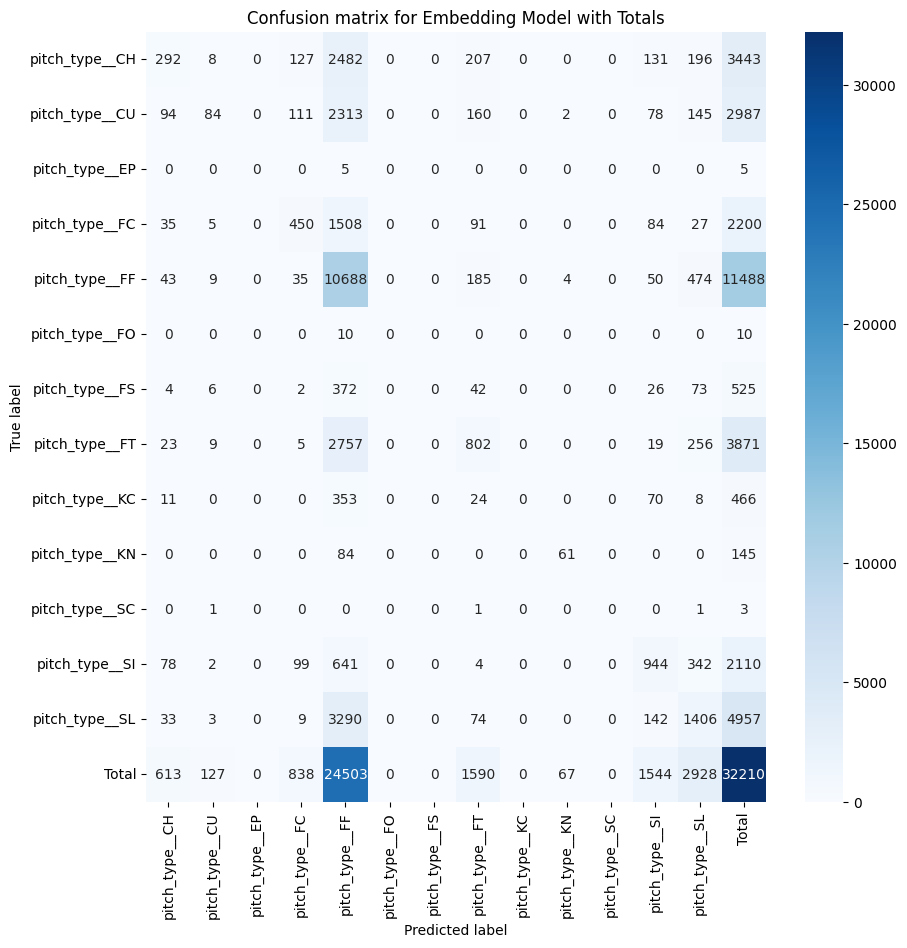

In [574]:
### Just looking at the best model in terms of accuracy (I know these are all bad, but with limited time just showing hte steps)


plt.figure(figsize=(10,10))
cm = confusion_matrix(test_labels, preds[1])
row_totals = cm.sum(axis=1, keepdims=True)
col_totals = cm.sum(axis=0, keepdims=True)

total = cm.sum()
col_totals = np.append(col_totals, total)

cm_with_totals = np.append(cm, row_totals, axis=1)
cm_with_totals = np.append(cm_with_totals, col_totals.reshape(1,-1), axis=0)

class_labels_with_totals = label_columns + ['Total']

sns.heatmap(cm_with_totals, annot=True, fmt='d', xticklabels=class_labels_with_totals, yticklabels=class_labels_with_totals, cmap='Blues')
plt.title(f'Confusion matrix for Embedding Model with Totals')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show();

In [583]:
###It's not as bad as I thought initially when looking at the results. FF only makes up around 35% of all pitches, so accuracy above that is pretty good. 
##The model predicts the more common pitch types more often, but it's good to see that it's not just predicting FF all the time etc.
## It does still seem to favor FF, so some things in the future I could try is undersampling those pitches to balance the classes a bit more, or adjust the weightings in the loss function
### Changeups and Curveballs despite being the third and fourth most common pitches are not predicted well by this model, but sliders and sinkers do OK
### I think finding a way to tip the model away from FF would be the most impactful

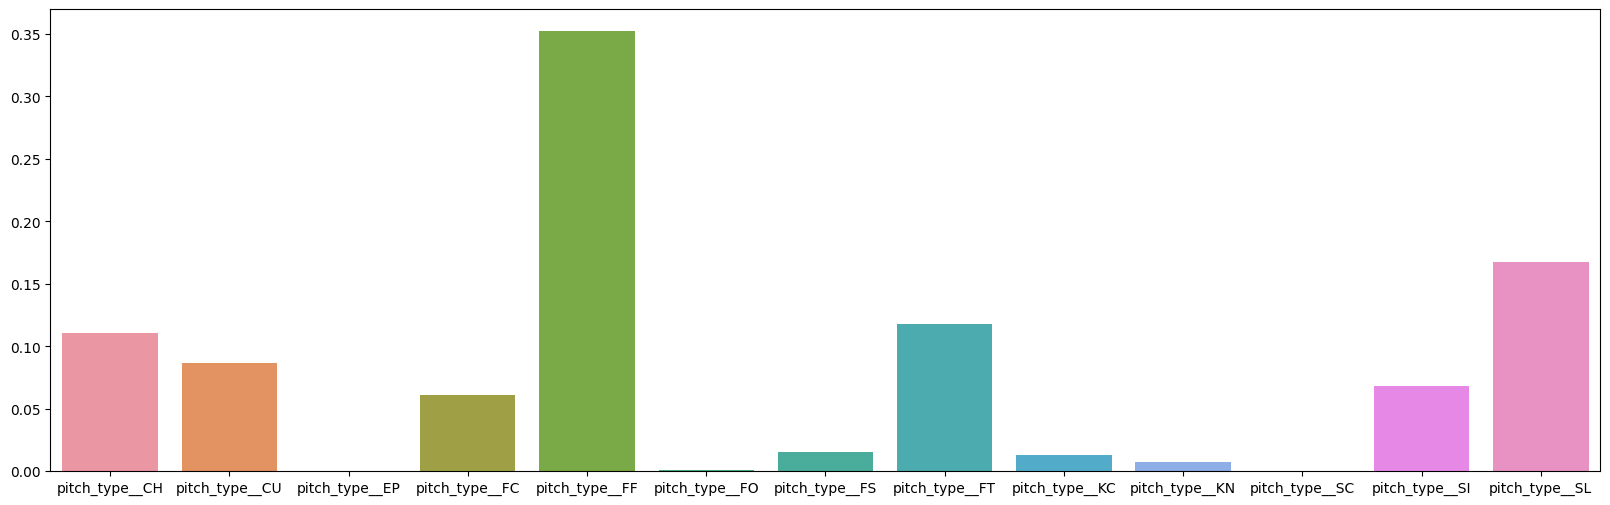

In [582]:
plt.figure(figsize=(20,6))
sns.barplot(x=label_columns, y=loss_weights.cpu().numpy())
plt.show;